In [1]:
import gc
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import rioxarray as rxr
from rioxarray.merge import merge_arrays
from rioxarray.merge import merge_datasets
from osgeo import gdal
from xarray.ufuncs import logical_or  as xr_or
import yaml
from datetime import datetime
import rasterio 

Selecting Bands:

In [23]:
# Directory with Landsat scene data
landsat_folder = '/home/spatialdays/Documents/ARD_Data/ARD_Landsat/ScaleValues/Scaled/LC08_L2SR_082071_20211126_tmp_2/LC08_L2SR_082071_20211126/'
#landsat_folder = '/home/spatialdays/Documents/ARD_Data/ARD_Landsat/ScaleValues/Scaled/LC08_L2SR_076071_20200910_tmp/LC08_L2SR_076071_20200910/'

# Select the QA Pixel Band
qa_band = landsat_folder + 'LC08_L2SR_082071_20211126_20211201_02_T1_QA_PIXEL.tif'
#qa_band = landsat_folder + 'LC08_L2SR_076071_20200910_20200923_02_T2_QA_PIXEL.tif'

# Directory with Sentinel-2 data
sentinel_folder = '/home/spatialdays/Documents/ARD_Data/ARD_Sentinel2/S2A_MSIL2A_20190124T221941_T60KYF_tmp/S2A_MSIL2A_20190124T221941_T60KYF_scaled/'

# Select sentinel scene classification band
sc_band = sentinel_folder + 'S2A_MSIL2A_20190124T221941_T60KYF_SCL_20m.tif'


Bitmasking functions from dc_Mosaic with slight adjustments:

In [16]:
def unpack_bits(land_cover_endcoding, data_array, cover_type):
    """
	Description:
		Unpack bits for end of ls7 and ls8 functions 
	-----
	Input:
		land_cover_encoding(dict hash table) land cover endcoding provided by ls7 or ls8
        data_array( xarray DataArray)
        cover_type(String) type of cover
	Output:
        unpacked DataArray
	"""
    boolean_mask = np.isin(data_array.values, land_cover_endcoding[cover_type])
    return xr.DataArray(boolean_mask.astype(bool),
                        coords=data_array.coords,
                        dims=data_array.dims,
                        name=cover_type + "_mask",
                        attrs=data_array.attrs)

def sen2_unpack_qa(data_array, cover_type):
    land_cover_endcoding = dict(fill=[0],
                                invalid=[1],
                                cast_shadows=[2],
                                cloud_shadows=[3],
                                vegetation=[4],
                                not_vegetated=[5],
                                water=[6],
                                unclassified=[7],
                                cloud_medium_prob=[8],
                                cloud_high_prob=[9],
                                thin_cirrus=[10],
                                snow_ice=[11],
                                clear = [4,5,6,11],
                                )
    return unpack_bits(land_cover_endcoding, data_array, cover_type)

def ls8_unpack_qa(data_array, cover_type):
    """
    Function from dc_mosaic.py
    """
    boolean_mask = np.zeros(data_array.shape, dtype=bool)
    data_array = data_array.astype(np.int64)

    if cover_type == 'clear':
        # 6th bit is clear
        boolean_mask |=  ((data_array & 0b0000000001000000) != 0)
    elif cover_type == 'water':
        # 7th bit is water
        boolean_mask |= ((data_array & 0b0000000010000000) != 0)
    else:
        raise ValueError(f"Cover type {cover_type} not supported for Landsat 8 yet")
    return boolean_mask

def qa_clean_mask(pixel_qa_band, platform, cover_types):
    """
    Function from dc_mosaic.py
    """
    processing_options = {
        #"LANDSAT_4": ls4_unpack_qa,
        #"LANDSAT_5": ls5_unpack_qa,
        #"LANDSAT_7": ls7_unpack_qa,
        "LANDSAT_8": ls8_unpack_qa,
        "SENTINEL_2": sen2_unpack_qa
    }

    clean_mask = None
    # Keep all specified cover types (e.g. 'clear', 'water'), so logically or the separate masks.
    
    if platform == "SENTINEL_2":
        for i, cover_type in enumerate(cover_types):
            cover_type_clean_mask = processing_options[platform](pixel_qa_band, cover_type)
            clean_mask = cover_type_clean_mask if i == 0 else xr_or(clean_mask, cover_type_clean_mask)
    
    else: 
        for i, cover_type in enumerate(cover_types):
            print(f'running cover_type: {cover_type}')
            cover_type_clean_mask = processing_options[platform](pixel_qa_band, cover_type)
            clean_mask = cover_type_clean_mask if i == 0 else xr_or(clean_mask, cover_type_clean_mask)

    return clean_mask

def rename_bands(in_xr, des_bands, position):
    in_xr.name = des_bands[position]
    return in_xr

Prepare data:

In [ ]:
# Read the QA Pixel Band as array
qa_arr = gdal.Open(qa_band).ReadAsArray()

# Read yml metadata
yml = landsat_folder + 'datacube-metadata.yaml'
with open (yml) as stream: yml_meta = yaml.safe_load(stream) 

# Define desired bands
des_bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'pixel_qa']

# Read bands with rioxarray
o_bands_data = [ rxr.open_rasterio(landsat_folder + yml_meta['image']['bands'][b]['path']) for b in des_bands ] 

# Access the pixel_qa band for bit masking
pixel_qa_band = o_bands_data[6]

for i in o_bands_data: i.close() # close the files

In [24]:
# For Sentinel2: 

# Read the scene classification band as array
sc_arr = gdal.Open(sc_band).ReadAsArray()

# Read yml metadata
yml = sentinel_folder + 'datacube-metadata.yaml'
with open (yml) as stream: yml_meta = yaml.safe_load(stream) 

# Define desired bands
des_bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'scene_classification']

# Read bands with rioxarray
o_bands_data = [ rxr.open_rasterio(sentinel_folder + yml_meta['image']['bands'][b]['path']) for b in des_bands ] 

# Access the pixel_qa band for bit masking
sc_band = o_bands_data[6]

for i in o_bands_data: i.close() # close the files

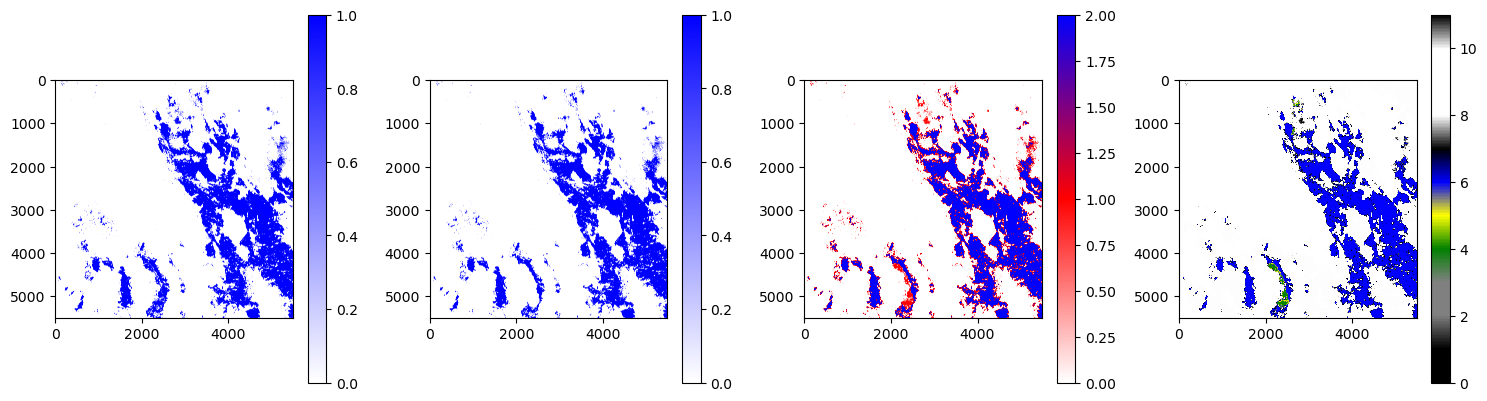

In [32]:
clear_mask = qa_clean_mask(sc_band, 'SENTINEL_2', ['clear'])
water_mask = qa_clean_mask(sc_band, 'SENTINEL_2', ['water'])

# Add the masks together to get a combined mask
combined_mask = clear_mask.astype(int) + water_mask.astype(int)

# Visualize masks in subplots with figure size 30,30
fig, axs = plt.subplots(1, 4, figsize=(15,15))

# Define the colormaps
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","blue"])
three_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","red", "blue"])

# Sentinel-2 Scene Classification Colormap
# 0: nodata, 1: saturated, 2: cast_shadows, 3: cloud_shadows, 4: vegetation, 5: not_vegetated, 6: water, 
# 7: unclassified, 8: cloud_medium_prob, 9: cloud_high_prob, 10: thin_cirrus, 11: snow_ice
sc_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["black","black", "gray", "gray", "green",
                                                            "yellow", "blue", "black", "white", "white", 
                                                            "white", "black"])

# Squeeze the mask arrays to visualize
clear_mask = np.squeeze(clear_mask)
water_mask = np.squeeze(water_mask)
combined_mask = np.squeeze(combined_mask)
sc_band = np.squeeze(sc_band)


# Visualize clear mask
clear_im = axs[0].imshow(clear_mask, cmap=custom_cmap)
plt.colorbar(clear_im, ax=axs[0], shrink=0.25)

# Visualize water mask
water_im = axs[1].imshow(water_mask, cmap=custom_cmap)
plt.colorbar(water_im, ax=axs[1], shrink=0.25)

# Visualize combined water + clear mask
combined_im = axs[2].imshow(combined_mask, cmap=three_cmap)
plt.colorbar(combined_im, ax=axs[2], shrink=0.25)

# Visualize original sc band
sc_im = axs[3].imshow(sc_band, cmap=sc_cmap, vmin=0, vmax=11)
plt.colorbar(sc_im, ax=axs[3], shrink=0.25)

plt.tight_layout()

Run bitmasking and visualize:

In [ ]:
# Run the clean mask function for clear and water
clear_mask = landsat_qa_clean_mask(pixel_qa_band, 'LANDSAT_8', cover_types=['clear'])
water_mask = landsat_qa_clean_mask(pixel_qa_band, 'LANDSAT_8', cover_types=['water'])

# Add the masks together to get a combined mask
combined_mask = clear_mask.astype(int) + water_mask.astype(int)

# Apply the masks to the scene
# TODO: Actually apply the masks - figure out how to do this if not using xr.merge because of image issues
#clear_scene = bands_data.where(clear_mask)
#water_scene = bands_data.where(water_mask)

# Write the masks to tif
clear_mask.rio.to_raster("clear_mask.tif", dtype="uint8")
water_mask.rio.to_raster("water_mask.tif", dtype="uint8")


# Visualize masks in subplots with figure size 30,30
fig, axs = plt.subplots(1, 3, figsize=(15,15))

# Define the colormaps
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","blue"])
three_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","red", "blue"])

# Squeeze the mask arrays to visualize
clear_mask = np.squeeze(clear_mask)
water_mask = np.squeeze(water_mask)
combined_mask = np.squeeze(combined_mask)


# Visualize clear mask
clear_im = axs[0].imshow(clear_mask, cmap=custom_cmap)
plt.colorbar(clear_im, ax=axs[0], shrink=0.25)

# Visualize water mask
water_im = axs[1].imshow(water_mask, cmap=custom_cmap)
plt.colorbar(water_im, ax=axs[1], shrink=0.25)

# Visualize combined mask
combined_im = axs[2].imshow(combined_mask, cmap=three_cmap)
plt.colorbar(combined_im, ax=axs[2], shrink=0.25)

plt.tight_layout()

Test applying masks:

In [ ]:

nir_band = rxr.open_rasterio(landsat_folder + yml_meta['image']['bands']['nir']['path'])
water_scene = nir_band.where(water_mask)
water_scene.rio.to_raster("water_scene.tif")


water_scene = water_scene.squeeze()

# Visualize masks in subplots with figure size 30,30
fig, axs = plt.subplots(1, 2, figsize=(15,15))


# Define the colormaps
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white","blue"])

# Visualize clear mask
water_masked_im = axs[0].imshow(water_scene, cmap=custom_cmap)
plt.colorbar(water_masked_im, ax=axs[0], shrink=0.25)